In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import netCDF4 as nc

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.neutral_transport import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="xcol1ab-newfluxlim-tests", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="xcol1a-base-tests", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),

]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])


CHECK: Total domain volume is 1.607E+00 [m3]


In [4]:
ds = casestore["base"].ds
ds = calculate_radial_fluxes(ds)

In [5]:
domain = ds
m = ds.metadata
Te = domain["Te"].values
Ta = domain["Td"].values
Ti = domain["Td+"].values
Ne = domain["Ne"].values
Na = domain["Nd"].values
Pa = domain["Pd"].values
Dn = domain["Dnnd"].values
Fa = domain["NVd"].values
Fi = domain["NVd+"].values
dx = domain["dx"].values
dy = domain["dy"].values
dz = domain["dz"].values
dl = ds["dl"].values
dr = ds["dr"].values
J = ds["J"].values
g11 = ds["g11"].values
q_e = constants("q_e")
mp = constants("mass_p")
me = constants("mass_e")

neut = NeutralTransport(domain, inputs = dict(
                                                Te = Te,
                                                Ta = Ta,
                                                Ti = Ti,
                                                Ne = Ne,
                                                Na = Na,
                                                Pa = Pa,
                                                dy = dy,
                                                dz = dz,
                                                dl = dl, 
                                                dr = dr,
                                                J = J,
                                                g11 = g11,
                                                dx = dx
                                                ))
neut.get_rates(reproduce_bug = True)
neut.get_Dn(collisions = ["cx", "nn", "ne", "ni", "nnlim"],
            flux_limiter = "none",
            alpha = 0.2)

ds["Dn_calc"] = (["x", "theta"], neut.Dn)
ds["Dn_calc"].attrs["metadata"] = ds.metadata

2D data detected


# Flux limiter factors

In [6]:
def get_ddx(f, dx):
    """
    This will give a gradient in dx only
    You have to convert it to dr yourself
    """
    dfdx = np.zeros_like(f)
    nx = f.shape[0]
    ny = f.shape[1]
    
    for i in range(nx):
        for j in range(ny):
            if i > 0 and i < nx-1 and j > 0 and j < ny-1:
                dfdx[i,j] = (f[i+1,j] - f[i-1,j]) / (2*dx[i,j])
    return dfdx

def get_ddy(f, dy):
    """
    This will give a gradient in dy only
    You have to convert it to dl yourself afterwards
    """
    dfdy = np.zeros_like(f)
    nx = f.shape[0]
    ny = f.shape[1]
    
    for i in range(nx):
        for j in range(ny):
            if i > 0 and i < nx-1 and j > 0 and j < ny-1:
                dfdy[i,j] = (f[i,j+1] - f[i,j-1]) / (2*dy[i,j])
    return dfdy

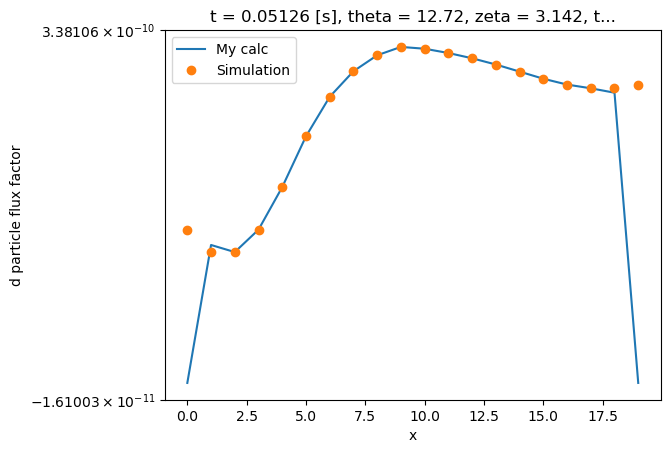

In [8]:
# v_perp * v_perp
dxnorm = m["rho_s0"]**2 * m["Bnorm"]   # Note dx is not in m!
dynorm = 1

f = ds["Pd"].values / m["Pnorm"]
dx = ds["dx"].values / dxnorm
dy = ds["dy"].values / dynorm
g_23 = ds["g_23"].values   # NOT UNNORMALISED IN LOAD YET - WATCH OUT
g23 = ds["g23"].values     # NOT UNNORMALISED IN LOAD YET - WATCH OUT
g33 = ds["g33"].values     # NOT UNNORMALISED IN LOAD YET - WATCH OUT
g11 = ds["g11"].values / ((m["Bnorm"] * m["rho_s0"])**2)
g22 = ds["g22"].values / (1/(m["rho_s0"] * m["rho_s0"]))
J = ds["J"].values / m["rho_s0"] / m["Bnorm"]
Bxy = ds["Bxy"].values

def get_grad_perp(f, dx, dy, J, Bxy, g11, g22, g33, g23, g_23):
    # g_12 is zero but g_23 is not
    # Below is from Grad_perp 
    # https://github.com/boutproject/BOUT-dev/blob/fd303eb903b82ad56a83e705599617279f4c3de7/src/field/vecops.cxx#L99
    x = get_ddx(f, dx)
    y = 0    # DDZ is zero, ignore bits from it
    z = g_23 * get_ddy(f, dy) / ((J * Bxy)**2)   # DDZ is zero, ignore bits from it

    # Now the dot product - both covariant so need to do this
    # https://github.com/boutproject/BOUT-dev/blob/master/src/field/vector3d.cxx#L469
    # Above function basically defines the symbol "*" as the below operation
    # Note if you have non-orthogonal grid this will break.
    result = x*x*g11 + y*y*g22 + z*z*g33   
    result += (y*z + z*y) * g23  # g12 and g13 zero, ignore those terms

    # Now magnitude, written as sqrt(v * v) where the "*" is the above operation
    # https://github.com/boutproject/BOUT-dev/blob/fd303eb903b82ad56a83e705599617279f4c3de7/src/field/vector3d.cxx#L599
    calc = np.sqrt(result)
    
    return calc

calc = result

fig, ax = plt.subplots()

# ------ Calculation
# calc = get_ddx(ds["Pd"].values / m["Pnorm"], ds["dx"].values / dxnorm)
# calc = get_ddy(ds["Pd"].values / m["Pnorm"], ds["dy"].values / dynorm)

ds["calc"] = (["x", "theta"], calc)
omp = ds.hermesm.select_region("outer_midplane_a")
omp["calc"].plot(ax = ax, label = "My calc")

# ------ xBOUT reference
# xbout = np.log(ds["Pd"]).bout.ddx() / m["Pnorm"] * m["rho_s0"]
# xbout.hermesm.select_region("outer_midplane_a").plot(ax = ax, label = "xBOUT")

# ----- Simulation
ref = omp["particle_flux_factor_d"]
ref.plot(ax = ax, label = "Simulation", lw = 0, marker = "o")

ax.legend()
print()
ax.set_yscale("symlog")




In [11]:
omp["g23"].values

array([5.30069343e-06, 4.66975090e-06, 4.28220210e-06, 4.03590809e-06,
       3.87567622e-06, 3.77120851e-06, 3.70562561e-06, 3.66505927e-06,
       3.63971113e-06, 3.62264381e-06, 3.60903445e-06, 3.59493038e-06,
       3.57736888e-06, 3.55445768e-06, 3.52524510e-06, 3.49014751e-06,
       3.45143811e-06, 3.41368691e-06, 3.36927881e-06, 3.30763614e-06])

In [12]:
omp["calc"].values

array([ 0.        , -0.00764383, -0.00764383, -0.00814596, -0.00881211,
       -0.00941736, -0.00986538, -0.01017262, -0.01038391, -0.01053986,
       -0.01067538, -0.0108228 , -0.01100874, -0.0112525 , -0.0115598 ,
       -0.01191325, -0.0122619 , -0.01251104, -0.01251104,  0.        ])

In [9]:
Pnorm

1.60217662

In [ ]:
fig, ax = plt.subplots()

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])


ax.plot(dist, omp["particle_flux_factor_d"] , label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["grad_lnP_perp_x"], label = "New calc", c = "red")

ax.legend(fontsize=8, loc = "upper right")
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Radial neutral flux $[m^{2}s^{-1}]$")
ax.set_title("Flux limiter factor")

Text(0.5, 1.0, 'Flux limiter factor')

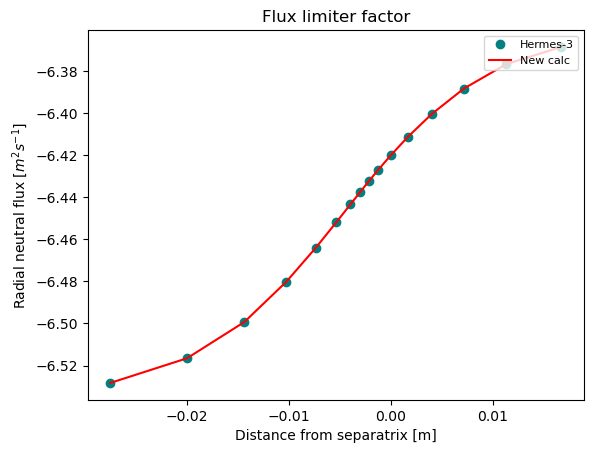

In [8]:
fig, ax = plt.subplots()

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

# Dn = omp["Dn_calc"]
# Vn = omp["NVd"] / (omp["Nd"] * mp*2)
# Pa = omp["Pd"]
# Na = omp["Nd"]
# Ta = omp["Td"]
# J = omp["J"]
# g_12 = omp["g_12"] * (1/m["Bnorm"])
# alpha = 1
# gamma = 2
# v_perp = omp["Dn_calc"] * np.log(omp["Pd"]).bout.ddx()

# ----- Normalised inputs
Pa = ds["Pd"].values / (m["Nnorm"] * m["Tnorm"] * q_e)
dr = ds["dr"].values / m["rho_s0"]

# ----- xBOUT operator
# lnP = np.log(ds["Pd"])
# grad_lnP_perp_x = lnP.bout.ddx() #- (ds["g_12"]/m["Bnorm"]) * lnP.bout.ddy() / np.sqrt(ds["J"] * ds["Bxy"])
# grad_lnP_perp_x *= ds["g11"]  # Because ddx returns covariant
# ds["grad_lnP_perp_x"] = (["x", "theta"], grad_lnP_perp_x.values)

# ----- Explicit operator

f = np.log(Pa)
nx = f.shape[0]
ny = f.shape[1]
dfdx = np.zeros_like(f)
dfdy = np.zeros_like(f)

for i in range(nx):
    for j in range(ny):
        if i > 0 and i < nx-1 and j > 0 and j < ny-1:
            dfdx[i,j] = (f[i+1,j] - f[i-1,j]) / (2*dr[i,j])
            # dfdy[i,j] = (f[i,j+1] - f[i,j-1]) / (2*dl[i,j])
ds["grad_lnP_perp_x"] = (["x", "theta"], dfdx)

ds["grad_lnP_perp_x"] = (["x", "theta"], f)

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
# v_perp = omp["Dn_calc"] * np.gradient(np.log(omp["Pd"]), dist)


# v_abs = np.sqrt(v_perp**2 + Vn**2)
# flux_abs = Na * v_abs
# particle_limit = Na * 0.25 * np.sqrt(8 * q_e*Ta / (np.pi*2*mp))
# particle_flux_factor = ( (flux_abs/(alpha * particle_limit))**gamma )**(-1/gamma)
# particle_flux_factor = v_perp

# ax.plot(dist, -omp["particle_flux_factor_d"] * m["rho_s0"]*m["Omega_ci"], label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["particle_flux_factor_d"] , label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["grad_lnP_perp_x"], label = "New calc", c = "red")

ax.legend(fontsize=8, loc = "upper right")
# ax.set_ymargin(0.1)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Radial neutral flux $[m^{2}s^{-1}]$")
# ax.set_yscale("log")
ax.set_title("Flux limiter factor")

In [ ]:
ds["grad_lnP_perp_x"].bout.polygon()

2D data detected


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Collision frequency ${\\alpha}$ $[s^{-1}]$')

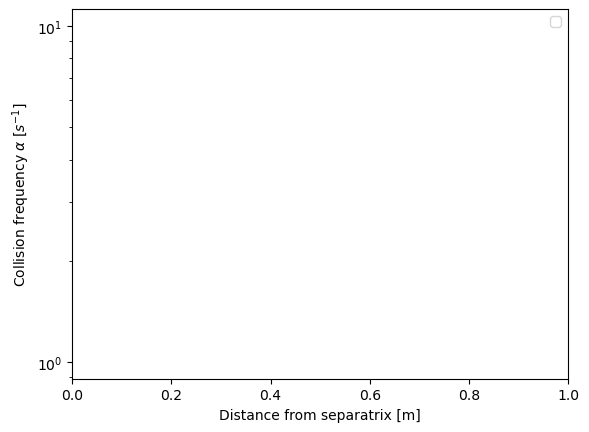

In [6]:
# domain = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
domain = ds
m = ds.metadata
Te = domain["Te"].values
Ta = domain["Td"].values
Ti = domain["Td+"].values
Ne = domain["Ne"].values
Na = domain["Nd"].values
Pa = domain["Pd"].values
Dn = domain["Dnnd"].values
Fa = domain["NVd"].values
Fi = domain["NVd+"].values
dx = domain["dx"].values
dy = domain["dy"].values
dz = domain["dz"].values
dl = ds["dl"].values
dr = ds["dr"].values
J = ds["J"].values
g11 = ds["g11"].values
q_e = constants("q_e")
mp = constants("mass_p")
me = constants("mass_e")

neut = NeutralTransport(domain, inputs = dict(
                                                Te = Te,
                                                Ta = Ta,
                                                Ti = Ti,
                                                Ne = Ne,
                                                Na = Na,
                                                Pa = Pa,
                                                dy = dy,
                                                dz = dz,
                                                dl = dl, 
                                                dr = dr,
                                                J = J,
                                                g11 = g11,
                                                dx = dx
                                                ))
neut.get_rates(reproduce_bug = True)
rates = neut.k

# Put rate back into dataset
for rate in rates:
    ds[rate] = (["x", "theta"], rates[rate])
    ds[rate].attrs["metadata"] = ds.metadata

omp = domain
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

fig, ax = plt.subplots()

# ax.plot(dist, omp["cx"], label = "CX")
# ax.plot(dist, omp["nn"], label = "NN", c = "darkorange")
# ax.plot(dist, omp["Kdd_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "darkorange")
# ax.plot(dist, omp["nnlim"], label = "NNlim", c = "teal")
# ax.plot(dist, omp["ne"], label = "NE", c = "firebrick")
# ax.plot(dist, omp["Kde_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "firebrick")
# ax.plot(dist, omp["ni"], label = "NI", c = "limegreen")
# ax.plot(dist, omp["Kdd+_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "limegreen")

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Collision frequency ${\\alpha}$ $[s^{-1}]$")

Text(0, 0.5, 'Neutral diffusion coefficient [$m^2$/s]')

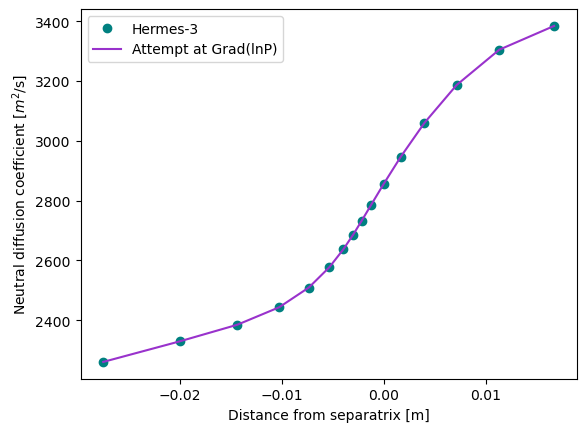

In [8]:
neut.get_Dn(collisions = ["cx", "nn", "ne", "ni", "nnlim"],
            flux_limiter = "none",
            alpha = 0.2)

ds["Dn_calc"] = (["x", "theta"], neut.Dn)
ds["Dn_calc"].attrs["metadata"] = ds.metadata


omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

fig, ax = plt.subplots()
ax.plot(dist, omp["Dnnd"], label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["Dn_calc"], label = "Attempt at Grad(lnP)", c = "darkorchid")

ax.legend()
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral diffusion coefficient [$m^2$/s]")
# ax.set_yscale("log")

# Flux

Text(0.5, 1.0, 'Face center flux comparison')

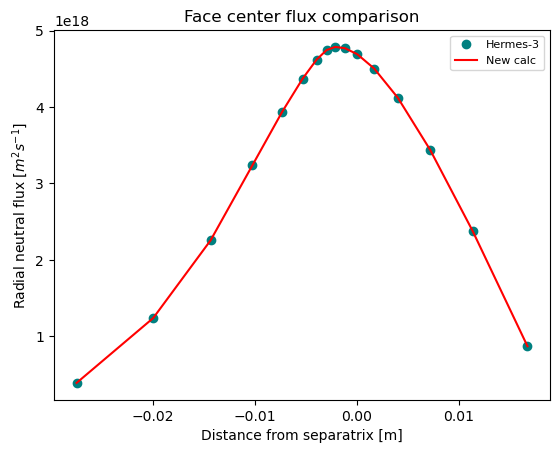

In [9]:
fig, ax = plt.subplots()


omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])
da = omp["dy"] * omp["dz"] 

flux_ref = (omp["pf_perp_diff_R_d"] + omp["pf_perp_diff_L_d"])/2 
    
neut.get_flux()
ds["flux_calc"] = (["x", "theta"], neut.flux)
ds["flux_calc"].attrs["metadata"] = ds.metadata
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])


ax.plot(dist, -flux_ref, label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, -omp["flux_calc"], label = "New calc", c = "red")

ax.legend(fontsize=8, loc = "upper right")
# ax.set_ymargin(0.1)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Radial neutral flux $[m^{2}s^{-1}]$")
# ax.set_yscale("log")
ax.set_title("Face center flux comparison")